# MS and BLEU on Paraphrases


**PLEASE INSTALL MOVERSCORE AS BELOW USING**
- https://drive.google.com/drive/folders/1SMHlJ338BHoJnkRiY-419EjLdFTHV91O?usp=sharing

Alternatively, please refer to https://github.com/AIPHES/emnlp19-moverscore

## Mount Drive and Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
! pip3 install -r /content/gdrive/MyDrive/NLP_EvaluationMetrics/MoverScore/requirements.txt
! pip3 install transformers
! pip3 install pytorch-pretrained-bert
! pip3 install moverscore
! pip3 install tdqm

In [ ]:
base_path_moverscore = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/MoverScoreBLEU/'

In [ ]:
# Get Device 
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


In [ ]:
## Use the original version with BERTMNLI to reproduce the results.
from moverscore import get_idf_dict, word_mover_score
## Recommend to use this version (DistilBERT) for evaluation, if the speed is your concern.
##from moverscore_v2 import get_idf_dict, word_mover_score 
from collections import defaultdict
import os
import pickle
import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import statistics
import string


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', -1)

[--------------------------------------------------]


## Calculating/Loading Scores on T5


In [ ]:
# Load paraphrases for calculation
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/T5_paraphrases/Phase3/'
with open(data_path+'data_paraphrased_model1.pkl', 'rb') as f:
  data = pickle.load(f)
data.columns = ['original', 'paraphrase']

In [ ]:
data['max_length'] = [max(len(sent.split()), len(ref.split())) for sent, ref in zip(data['original'], data['paraphrase'])]
data['min_length'] = [min(len(sent.split()), len(ref.split())) for sent, ref in zip(data['original'], data['paraphrase'])]
len(data)

105000

In [ ]:
data = data.loc[data['min_length']>=3]
len(data)

104999

In [ ]:
# Workaround used because of woring order of applciation of COLA and MS
#data_cache = pd.read_excel(data_path+'cola_filtered+score.xlsx')
#data_cache.head()
#data_cache.to_pickle(data_path+'data_paraphrased_with_scores.pkl')

In [ ]:
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/T5_paraphrases/Phase3/'

filename_dataframe = 'data_paraphrased_with_scores.pkl'

try:
  # Try to read already calculated data
  data_scored =  pd.read_pickle(data_path + filename_dataframe)

except FileNotFoundError:
  print(f'Data does not exist yet! Calculating scores now ... ')

  # Load paraphrases for calculation
  #with open(data_path+'data_paraphrased.pkl', 'rb') as f:
    #data = pickle.load(f)
  #data.columns = ['original', 'paraphrase']

  # Setup data structure
  data_scored = pd.DataFrame(columns=['original', 'paraphrase', 'MoverScore', 'BLEU'])

  # Get idf dicts 
  idf_dict_hyp = get_idf_dict(data['original']) # idf_dict_hyp = defaultdict(lambda: 1.)
  idf_dict_ref = get_idf_dict(data['paraphrase']) # idf_dict_ref = defaultdict(lambda: 1.)

  # BLEU helpers
  translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  smoothie = SmoothingFunction().method4
  
  # calculate moverscores
  #THIS MIGHT BE IMPROVED WITH BETTER BATCHING
  for i, (ref, tran) in tqdm.notebook.tqdm(enumerate(zip(data['original'], data['paraphrase'])), total = len(data['paraphrase'])):

    # Calc Moverscore
    score_MS = word_mover_score([ref], [tran], idf_dict_ref, idf_dict_hyp, stop_words=[], n_gram=4, remove_subwords=True)
    
    # Calc BLEU
    score_BLEU = sentence_bleu(references=[ref.translate(translator).lower().split()], hypothesis=tran.translate(translator).lower().split(), weights=(.25, .25, .25, .25), smoothing_function=smoothie)

    # Storing data in dataframe
    data_scored = data_scored.append(pd.DataFrame([[ref, tran, score_MS[0], score_BLEU]], 
                                              columns=['original', 'paraphrase', 'MoverScore', 'BLEU']),
                                              ignore_index=True)

  # After all sentences are done: Save data
  print('Saving data to :\t', data_path + filename_dataframe )
  data_scored.to_pickle(data_path + filename_dataframe)

finally:
  print('Done!')

Done!


In [ ]:
print(f'Mean of BLEU', data_scored['BLEU'].mean())
print(f'Mean of MS', data_scored['MoverScore'].mean())

Mean of BLEU 0.24722168377223105
Mean of MS 0.6022756020437136


In [ ]:
def F1(x,y):
  return 2*(x*y)/(x+y)    
def z_score(data):
  data = (data-np.mean(data))/np.std(data)    
  return data   

In [ ]:
data_scored['F1']= [F1(MS,1-B) for MS,B in zip(data_scored['MoverScore'],data_scored['BLEU'])]
data_scored = data_scored.sort_values(by =['F1'], ascending = False)

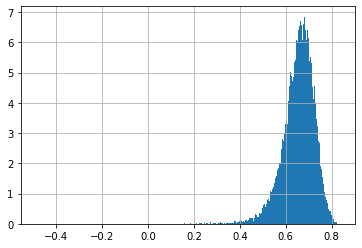

In [ ]:
data_scored['F1'].hist(density= True, bins = 1000)

In [ ]:
#data_scored.head(40)

In [ ]:
#data_scored.tail(40)

In [ ]:
print(f'Remaining: {len(data_scored)} sentence pairs!')
data_scored['F1_Zscore']= z_score(data_scored['F1'])
data_scored_subset = data_scored[np.abs(data_scored['F1_Zscore'])<1]
print(f'Remaining: {len(data_scored_subset)} sentence pairs!')

Remaining: 104999 sentence pairs!
Remaining: 76597 sentence pairs!


In [ ]:
data_scored_subset.head(40)

In [ ]:
#data_scored_subset.tail(40)

In [ ]:
# After all sentences are done: Save data
data_scored.to_pickle(data_path + 'data_paraphrased_with_F1.pkl')
# After all sentences are done: Save data
data_scored_subset.head(75000).to_pickle(data_path + 'data_paraphrased_Z-filtered_75K.pkl')

In [ ]:
data_T5_scored = data_scored

## Calculating/Loading Scores on GPT2

---




In [ ]:
# Load paraphrases for calculation
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/GPT2_paraphrases/Phase3/'
#with open(data_path+'cleaned_df_gpt2.pkl', 'rb') as f:
  #data_gpt2 = pickle.load(f)
data_gpt2=pd.read_csv(data_path+'gpt_2_105k_para.csv')
#data_gpt2 = data_gpt2.drop(columns = ['Unnamed: 0'])
data_gpt2.columns = ['original', 'paraphrase']

In [ ]:
print(f'Num sentences: {len(data_gpt2)}')
data_gpt2.head()

Num sentences: 104997


,original,paraphrase
0,in the last years wireless communication systems coped with the problem of delivering reliable information while granting high throughput.,"in recent years, the problem of reliable information delivery has been addressed by wireless systems that have been able to handle high-speed data"
1,several works addressed the parallelization of turbo decoder architectures to achieve higher throughput.,several projects have been developed to parallelize the architecture of the turbo decoder.
2,"thus, together with flexible and high throughput processing elements, a multi-asip architecture must feature also a flexible and high throughput interconnection backbone.","a multi-asip architecture must also include a flexible and high-speed connection backbone, which is also a multi-asip architecture."
3,in this work a general framework to design network on chip based turbo decoder architectures has been presented.,a general framework for the design of a network on chip based on a turbo decoder has been presented in this work.
4,"the proposed framework can be adapted to explore different topologies, degrees of parallelism, message injection rates and routing algorithms.","the framework can be adapted to examine different topologies, degrees of parallelism, message injection rates and routing algorithms."


In [ ]:
data_gpt2['max_length'] = [max(len(sent.split()), len(ref.split())) for sent, ref in zip(data_gpt2['original'], data_gpt2['paraphrase'])]
data_gpt2['min_length'] = [min(len(sent.split()), len(ref.split())) for sent, ref in zip(data_gpt2['original'], data_gpt2['paraphrase'])]
print(f'Num sentences: {len(data_gpt2)}')

Num sentences: 104997


In [ ]:
data_gpt2 = data_gpt2.loc[data_gpt2['min_length']>=3]
print(f'Num sentences: {len(data_gpt2)}')

Num sentences: 104900


In [ ]:
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/GPT2_paraphrases/Phase3/'

filename_dataframe = 'cleaned_df_gpt2_with_scores.pkl'

try:
  # Try to read already calculated data
  data_gpt2_scored =  pd.read_pickle(data_path + filename_dataframe)

except FileNotFoundError:
  print(f'Data does not exist yet! Calculating scores now ... ')

  # Load paraphrases for calculation
  #with open(data_path+'data_paraphrased.pkl', 'rb') as f:
    #data = pickle.load(f)
  #data.columns = ['original', 'paraphrase']

  # Setup data structure
  data_gpt2_scored = pd.DataFrame(columns=['original', 'paraphrase', 'MoverScore', 'BLEU'])

  # Get idf dicts 
  idf_dict_hyp = get_idf_dict(data_gpt2['original']) # idf_dict_hyp = defaultdict(lambda: 1.)
  idf_dict_ref = get_idf_dict(data_gpt2['paraphrase']) # idf_dict_ref = defaultdict(lambda: 1.)

  # BLEU helpers
  translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  smoothie = SmoothingFunction().method4
  
  # calculate moverscores
  #THIS MIGHT BE IMPROVED WITH BETTER BATCHING
  for i, (ref, tran) in tqdm.notebook.tqdm(enumerate(zip(data_gpt2['original'], data_gpt2['paraphrase'])), total = len(data_gpt2['paraphrase'])):

    # Calc Moverscore
    score_MS = word_mover_score([ref], [tran], idf_dict_ref, idf_dict_hyp, stop_words=[], n_gram=4, remove_subwords=True)
    
    # Calc BLEU
    score_BLEU = sentence_bleu(references=[ref.translate(translator).lower().split()], hypothesis=tran.translate(translator).lower().split(), weights=(.25, .25, .25, .25), smoothing_function=smoothie)

    # Storing data in dataframe
    data_gpt2_scored = data_gpt2_scored.append(pd.DataFrame([[ref, tran, score_MS[0], score_BLEU]], 
                                              columns=['original', 'paraphrase', 'MoverScore', 'BLEU']),
                                              ignore_index=True)

  # After all sentences are done: Save data
  print('Saving data to :\t', data_path + filename_dataframe )
  data_gpt2_scored.to_pickle(data_path + filename_dataframe)

finally:
  print('Done!')

Done!


In [ ]:
print(f'Mean of BLEU', data_gpt2_scored['BLEU'].mean())
print(f'Mean of MS', data_gpt2_scored['MoverScore'].mean())

Mean of BLEU 0.35285961338716093
Mean of MS 0.6484123554572696


In [ ]:
data_gpt2_scored['F1']= [F1(MS,1-B) for MS,B in zip(data_gpt2_scored['MoverScore'],data_gpt2_scored['BLEU'])]
#data_gpt2_scored.to_pickle(data_path + 'cleaned_df_gpt2_with_scores_F1.pk')

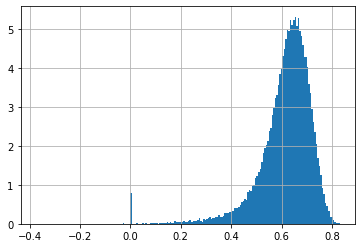

In [ ]:
data_gpt2_scored['F1'].hist(bins = 200, density = True)

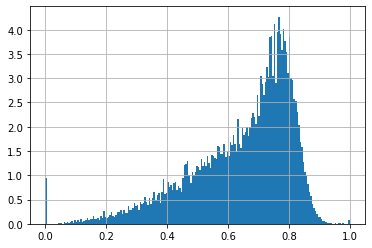

In [ ]:
(1-data_gpt2_scored['BLEU']).hist(bins = 200, density = True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


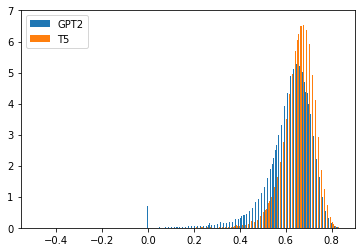

In [ ]:
plt.hist([data_gpt2_scored['F1'],data_T5_scored['F1']], label=['GPT2', 'T5'], bins = 200, density=True)
plt.legend()
plt.show()

In [ ]:
#data_gpt2_scored.head(40)

In [ ]:
#data_gpt2_scored.tail(40)

In [ ]:
print(f'Remaining: {len(data_gpt2_scored)} sentence pairs!')
data_gpt2_scored['F1_Zscore']= z_score(data_gpt2_scored['F1'])
data_gpt2_scored_subset = data_gpt2_scored[np.abs(data_gpt2_scored['F1_Zscore'])<1]
print(f'Remaining: {len(data_gpt2_scored_subset)} sentence pairs!')

Remaining: 104900 sentence pairs!
Remaining: 82616 sentence pairs!


In [ ]:
# After all sentences are done: Save data
data_gpt2_scored.to_pickle(data_path + 'data_gpt2_paraphrased_with_F1.pkl')
# After all sentences are done: Save data
data_gpt2_scored_subset.head(75000).to_pickle(data_path + 'data_gpt2_paraphrased_Z-filtered_75K.pkl')

In [ ]:
#data_gpt2_scored_subset

In [ ]:
# After all sentences are done: Save data
data_gpt2_scored.to_pickle(data_path + 'data_paraphrased_F1.pkl')

## Comparison
Note that the datasets differ slightly due to filtering, but this is neglectable due to the large amount of data.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


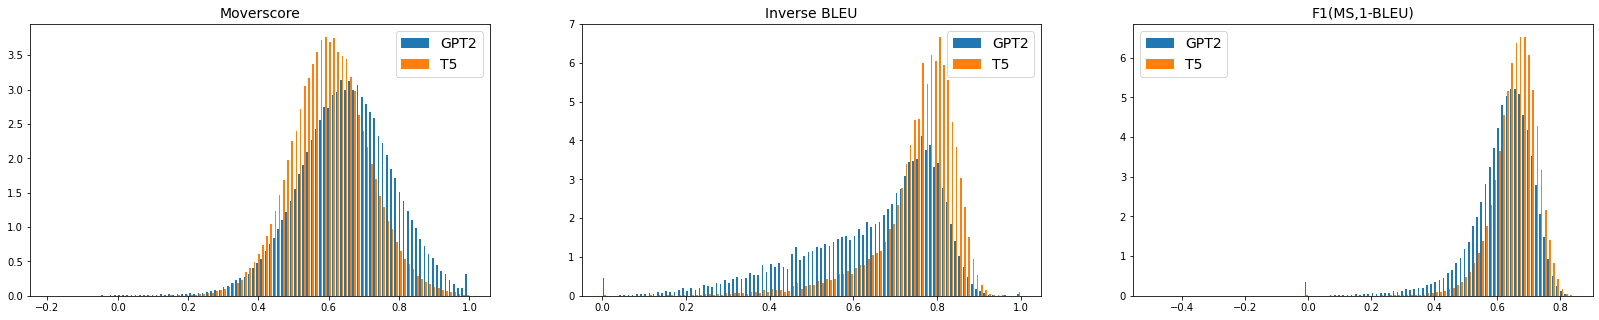

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (28,5))


ax[0].hist([data_gpt2_scored['MoverScore'], data_T5_scored['MoverScore']], bins = 100, label = ['GPT2', 'T5'], density = True)
ax[0].set_title('Moverscore', fontsize = 14)
ax[0].legend(fontsize = 14)
ax[1].hist([1-data_gpt2_scored['BLEU'], 1-data_T5_scored['BLEU']], bins = 100, label = ['GPT2', 'T5'], density = True)
ax[1].set_title('Inverse BLEU', fontsize = 14)
ax[1].legend(fontsize = 14)
ax[2].hist([data_gpt2_scored['F1'], data_T5_scored['F1']], bins = 100, label = ['GPT2', 'T5'], density = True)
ax[2].set_title('F1(MS,1-BLEU)', fontsize = 14)
ax[2].legend(fontsize = 14)

plt.show()

In [ ]:
data_gpt2_scored.sort_values(by='BLEU', ascending=False).head(40)

,original,paraphrase,MoverScore,BLEU,F1,F1_Zscore
36420,both of these alternatives are reasonable.,both of these alternatives are reasonable.,0.998289,1.0,0.0,-5.847205
98120,"therefore, the following theorem can be stated.","therefore, the following theorem can be stated.",0.983182,1.0,0.0,-5.847205
91624,we show the recovered frame corresponding to the object moving at the fastest speed.,we show the recovered frame corresponding to the object moving at the fastest speed.,0.995098,1.0,0.0,-5.847205
83587,this proves the first part of the theorem.,this proves the first part of the theorem.,0.983421,1.0,0.0,-5.847205
55578,the measurement matrix was assumed to be gaussian.,the measurement matrix was assumed to be Gaussian.,0.995301,1.0,0.0,-5.847205
83577,methods for learning with partial feedback.,methods for learning with partial feedback.,0.993942,1.0,0.0,-5.847205
13405,the symmetric boolean functions can be efficiently implemented.,the symmetric boolean functions can be efficiently implemented.,0.994447,1.0,0.0,-5.847205
9812,the main limitation of this approach is that the present method does not work well for classes where the rcnn results are weak.,the main limitation of this approach is that the present method does not work well for classes where the rcnn results are weak.,0.990076,1.0,0.0,-5.847205
91687,the results are more diverse (cf.,the results are more diverse (cf.,0.996749,1.0,0.0,-5.847205
51722,e-band offers a cost-effective and flexible alternative to fiber for future backhaul.,e-band offers a cost-effective and flexible alternative to fiber for future backhaul.,0.989993,1.0,0.0,-5.847205


In [ ]:
data_gpt2_scored = data_gpt2_scored.sort_index(ascending=True)
data_gpt2_scored.head()

,original,paraphrase,MoverScore,BLEU,F1,F1_Zscore
0,in the last years wireless communication systems coped with the problem of delivering reliable information while granting high throughput.,"in recent years, the problem of reliable information delivery has been addressed by wireless systems that have been able to handle high-speed data",0.544882,0.152452,0.663321,0.449819
1,several works addressed the parallelization of turbo decoder architectures to achieve higher throughput.,several projects have been developed to parallelize the architecture of the turbo decoder.,0.483294,0.210614,0.599531,-0.155749
2,"thus, together with flexible and high throughput processing elements, a multi-asip architecture must feature also a flexible and high throughput interconnection backbone.","a multi-asip architecture must also include a flexible and high-speed connection backbone, which is also a multi-asip architecture.",0.589108,0.281490,0.647406,0.298741
3,in this work a general framework to design network on chip based turbo decoder architectures has been presented.,a general framework for the design of a network on chip based on a turbo decoder has been presented in this work.,0.755267,0.259816,0.747649,1.250368
4,"the proposed framework can be adapted to explore different topologies, degrees of parallelism, message injection rates and routing algorithms.","the framework can be adapted to examine different topologies, degrees of parallelism, message injection rates and routing algorithms.",0.926009,0.747014,0.397401,-2.074601


In [ ]:
data_T5_scored = data_T5_scored.sort_index(ascending=True)
data_T5_scored.head()

,Unnamed: 0,original,paraphrase,MoverScore,BLEU,label,F1,F1_Zscore
0,0,in the last years wireless communication systems coped with the problem of delivering reliable information while granting high throughput.,wireless communication systems have dealt with the problems of providing reliable information at high speeds in recent years.,0.656146,0.197498,1,0.721981,0.940052
1,1,several works addressed the parallelization of turbo decoder architectures to achieve higher throughput.,"to increase the speed, several projects have investigated the parallelisation of turbo decoder architectures.",0.648949,0.204480,1,0.714798,0.836903
2,2,"thus, together with flexible and high throughput processing elements, a multi-asip architecture must feature also a flexible and high throughput interconnection backbone.",it must thus provide a flexible and high-speed interconnection basis in addition to the flexible and high-speed processing components.,0.630068,0.167375,1,0.717321,0.873130
3,3,in this work a general framework to design network on chip based turbo decoder architectures has been presented.,the work was presented in general framework for the design of turbo decoder networks.,0.575493,0.195831,1,0.670880,0.206213
4,4,"the proposed framework can be adapted to explore different topologies, degrees of parallelism, message injection rates and routing algorithms.","the different topologies and degrees of parallelism, the rate of insertion and rewriting algorithms can be studied with the help of this model.",0.539129,0.169184,1,0.653919,-0.037344


## Creating Z-scores and producing final data for M2 to be trained on

In [ ]:
data_final = data_T5_scored 

data_final['F1_Zscore']= z_score(data_final['F1'])
data_final = data_final[np.abs(data_final['F1_Zscore'])<1]

# SAVE DATA

In [ ]:
data_final.head(20)

In [ ]:
data_final.tail(20)